# INF200 Lecture No J05 / Model Dynamics

### Hans Ekkehard Plesser with material by Jonas van den Brink
### 14 January 2019

## Today's topics
- Classic population dynamics models
- Examples of BioSim Dynamics
- Analysis of BioSim Dynamics
- From discrete to continuous diffusion models

## Classic models

### Lotka-Volterra model

- Classic model of predator-prey population dynamics
- Each species is represented by a single density variable
- Dynamics are described by coupled, non-linear differential equations
\begin{align}
\dot{x} &= \alpha x - \beta x y  \\
\dot{y} &= \delta xy - \gamma y 
\end{align}
where $x$ is prey and $y$ is predator.
- Notes:
    - Solutions are continuous functions
    - Fractional values for $x$ and $y$ are possible, and animals never become extinct
    - One can remove three out of the four parameters by re-scaling
- See also [Wikipedia](https://en.wikipedia.org/wiki/Lotka–Volterra_equations)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12, 4)

In [3]:
def du_dt(u, t=0):
    alpha = 1.0 # growth of prey
    beta = 0.1  # rate of predation
    delta = 0.075 # growth of predators
    gamma = 1.5 # decay of predators

    x, y = u
    return np.array([alpha*x - beta*x*y, delta*x*y - gamma*y])

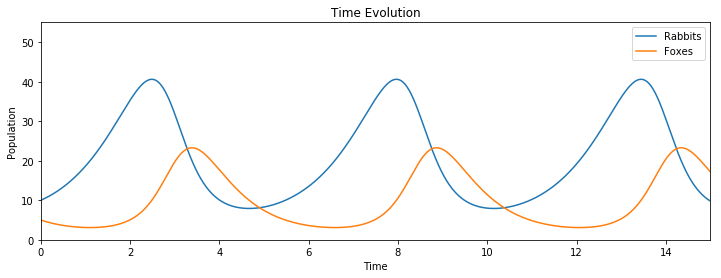

In [4]:
t = np.linspace(0, 15, 100001)
u = scipy.integrate.odeint(du_dt, (10, 5), t)

rabbit, fox = u[:, 0], u[:, 1]

plt.plot(t, rabbit)
plt.plot(t, fox)
plt.legend(['Rabbits', 'Foxes'])
plt.axis([0, 15, 0, 55])
plt.title('Time Evolution')
plt.xlabel('Time')
plt.ylabel('Population');

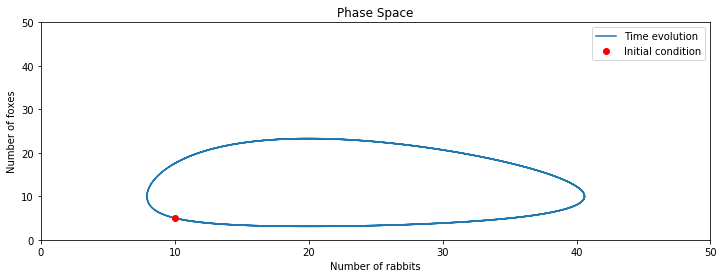

In [5]:
plt.plot(rabbit, fox)
plt.title('Phase Space')
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.axis([0, 50, 0, 50])
plt.plot(10, 5, 'ro')
plt.legend(['Time evolution', 'Initial condition']);

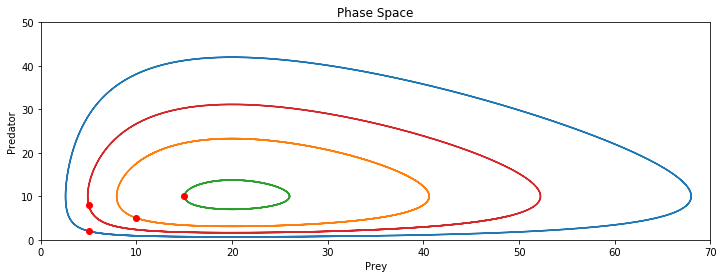

In [6]:
for u0 in [(5, 2), (10, 5), (15, 10), (5, 8)]:
    u = scipy.integrate.odeint(du_dt, u0, t)
    plt.plot(u[:,0], u[:,1])
    plt.plot(u0[0], u0[1], 'ro')

plt.title('Phase Space')
plt.xlabel('Prey')
plt.ylabel('Predator')
plt.axis([0, 70, 0, 50]);

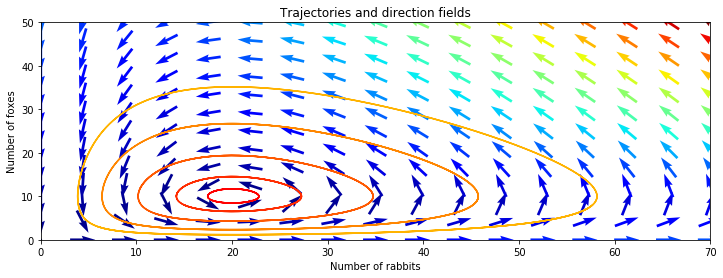

In [7]:
# Plot trajectories
values = ((6, 3), (9, 4), (12, 6), (15, 8), (18, 9))
colors = plt.cm.autumn_r(np.linspace(0.3, 1., len(values)))

for u0, col in zip(values, colors):
    u = scipy.integrate.odeint(du_dt, u0, t)
    plt.plot(u[:,0], u[:,1], color=col)

# Plot phase space direction arrows
x = np.linspace(0, 70, 17)
y = np.linspace(0, 50, 13)
X, Y = np.meshgrid(x, y)
DX, DY = du_dt([X, Y])

# Normalize direction vectors
M = np.hypot(DX, DY)
M[M == 0] = 1.                                 # Avoid zero division errors
DX /= M                                        # Normalize each arrows
DY /= M

plt.title('Trajectories and direction fields')
plt.quiver(X, Y, DX, DY, M, pivot='mid', cmap=plt.cm.jet)
plt.xlabel('Number of rabbits')
plt.ylabel('Number of foxes')
plt.axis([0, 70, 0, 50]);


#### The Lotka-Volterra is quite different from the BioSim model

- No spatial distribution (comparable to a single BioSim cell)
- Continuous, rather than discrete, in time
- Assumes infinite fodder for the prey/herbivores
- No random elements, it is a fully deterministic model

## Examples of BioSim dynamics

- The examples below have been prepared using Plesser's reference implementation

### Animals in a single Jungle cell

- 50 herbivores with random age and weight placed at start
- Simulated 50 years
- 5 carnivores with random age and weight placed
- Simulate 250 years
- Simulations with five different seeds
- See `Project/population_generator.py` for code generation populations

<img src="figures/mono_s1__00005.png" width=60%>
<img src="figures/mono_s2__00005.png" width=60%>
<img src="figures/mono_s3__00005.png" width=60%>
<img src="figures/mono_s4__00005.png" width=60%>
<img src="figures/mono_s5__00005.png" width=60%>




### Sample simulations

#### check_sim.py as posted
- 100 years only herbivores
- 100 years with also carnivores

<img src="figures/check_sim.pdf" width="70%">

#### check_sim.py with longer times
- **200** years only herbivores
- **200** years with also carnivores

<img src="figures/check_sim_long.pdf" width="70%">

### Complete simulation

- Full example island
- 200 herbivores and 50 carnivores, all age 5, weight 20, placed at (2,7) at beginning

<img src="figures/sas_s1_00000.png" width="70%">
<img src="figures/sas_s1_00200.png" width="70%">
<img src="figures/sas_s1_00399.png" width="70%">


### Migration only

- For testing purposes
- Particular parameter settings
    - No death, birth, or eating
    - All animals with age 5, weight 50
```python
    sim.set_animal_parameters('Herbivore',
                              {'mu': 1, 'omega': 0, 'gamma': 0,
                               'a_half': 1000})
    sim.set_animal_parameters('Carnivore',
                              {'mu': 1, 'omega': 0, 'gamma': 0,
                               'F': 0, 'a_half': 1000})
```
- 1000 herbivores placed in center

<img src="figures/mig_00000.png" width="60%">
<img src="figures/mig_00001.png" width="60%">
<img src="figures/mig_00002.png" width="60%">
<img src="figures/mig_00003.png" width="60%">
<img src="figures/mig_00004.png" width="60%">
<img src="figures/mig_00005.png" width="60%">
<img src="figures/mig_00010.png" width="60%">
<img src="figures/mig_00029.png" width="60%">

## Exploring the BioSim Model

To have a better understanding of a complex and connected model, it is usefull to simplify it and break it into components, which is what we will do now.

This is simply an exploration, not a definite analysis.

### Herbivores

First we look at the herbivores. We only look at the standard set of parameters here

In [8]:
hp = {'w_birth': 8.,
      'sigma_birth': 1.5,
      'beta': 0.9,
      'eta': 0.05,
      'a_half': 40.,
      'phi_age': 0.2,
      'w_half': 10.,
      'phi_weight': 0.1,
      'mu': 0.25,
      'lambda': 1.,
      'gamma': 0.2,
      'zeta': 3.5,
      'xi': 1.2,
      'omega': 0.4,
      'F': 10.}

#### Fitness function
The Fitness function is defined as the product of two sigmoidal functions, one for age and one for weight.
    $$q^+ = \frac{1}{1+\exp[{\phi_{\rm age}({\rm age} - {\rm age}_{1/2})}]}, \qquad q^- = \frac{1}{1+\exp[-{\phi_{\rm weight}({\rm weight} - {\rm weight}_{1/2})}]}$$

If you look closer at the functions, the biggest difference between them is the sign of the exponent, this makes the age-function monotonically decreasing, and the weight-function monotonically increasing. Let us plot them to get a better view

In [9]:
def q(sgn, x, xhalf, phi):
    return 1. / (1. + np.exp(sgn * phi * (x - xhalf)))

def Phi(a, w, p=hp):
    return (q(+1, a, p['a_half'], p['phi_age'])
            * q(-1, w, p['w_half'], p['phi_weight']))

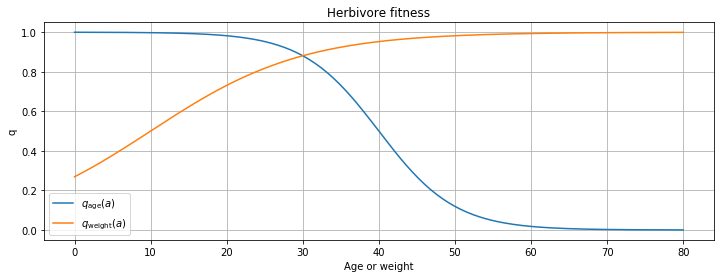

In [10]:
x = np.linspace(0, 80, 201);
plt.plot(x, q(+1, x, hp['a_half'], hp['phi_age']), label='$q_{\mathrm{age}}(a)$');
plt.plot(x, q(-1, x, hp['w_half'], hp['phi_weight']), label='$q_{\mathrm{weight}}(a)$');

plt.title('Herbivore fitness');
plt.legend();
plt.xlabel('Age or weight');
plt.ylabel('q');
plt.grid();

Interpretation: As the two functions are multiplied together to yield the fitness, an animal is fitter the younger and heavier it is. A starving or old animal can never be fit.

- From this it might seem that fittest animals are heavy newborns, but is this the case?
- We look closer at the fitnesses of newborn and their parents at the time of birth
    1. Newborns are born with weight $\mathcal{N}(w_b, \sigma)$
        - Newborns usually have fitnesses in $\Phi(0, [w_b \pm 2\sigma]$).
    1. To be able to give birth, a parent needs a weight of at least $\zeta(w_b + \sigma)$.
    1. Since we often have $N>10$ animals in a cell, each animal almost certainly gives birth as soon as it has the minimum weight required.
- Lowest birth-giving weight
    - animal ate at beginning of year and just made it across threshold
    - weight: $\zeta(w_b + \sigma)$
- Highest birth-giving weight
    - animal was just below threshold the previous year
    - lost weight at end of previous year
    - ate this year
    - weight: $(1-\eta)\zeta(w_b+\sigma) + \beta F$
- "Lowest" parent weight after birth (lightest parent, heaviest baby)
    - weight: $\zeta(w_b + \sigma) - \xi(w_b + 2\sigma)$
- "Highest" parent weight after birth (heaviest parent, lightest baby)
    - weight: $(1-\eta)\zeta(w_b+\sigma) + \beta F - \xi(w_b - 2\sigma)$

In [11]:
def plot_pf(age, clr):
    lo = ( hp['zeta'] * (hp['w_birth']+hp['sigma_birth'])
           - hp['xi'] * (hp['w_birth']+2*hp['sigma_birth']) )
    hi = ( (1-hp['eta'])*hp['zeta']*(hp['w_birth']+hp['sigma_birth'])
                     + hp['beta']*hp['F']
                     - hp['xi']*(hp['w_birth']-2*hp['sigma_birth']) )
    plt.fill_between(x, Phi(age*np.ones_like(x), lo), 
                        Phi(age*np.ones_like(x), hi), 
                 color=clr, alpha=.2, label=r'Parent fitness ($a={}$)'.format(age))

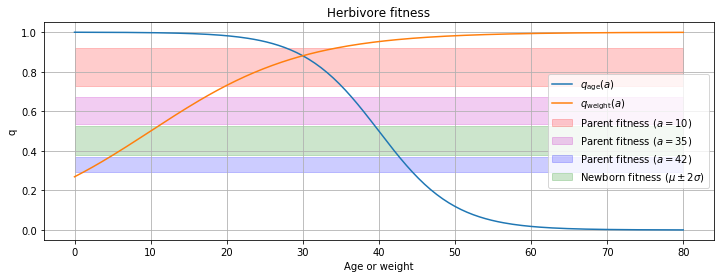

In [12]:
x = np.linspace(0, 80, 201);
plt.plot(x, q(+1, x, hp['a_half'], hp['phi_age']), label='$q_{\mathrm{age}}(a)$');
plt.plot(x, q(-1, x, hp['w_half'], hp['phi_weight']), label='$q_{\mathrm{weight}}(a)$');

plot_pf(10, 'r')
plot_pf(35, 'm')
plot_pf(42, 'b')
plt.fill_between(x, 
                 Phi(np.zeros_like(x), hp['w_birth']-2*hp['sigma_birth']), 
                 Phi(np.zeros_like(x), hp['w_birth']+2*hp['sigma_birth']), 
                 color='g', alpha=.2, label=r'Newborn fitness $(\mu\pm 2\sigma)$')


plt.title('Herbivore fitness');
plt.legend();
plt.xlabel('Age or weight');
plt.ylabel('q');
plt.grid();

Observations from the figure:
- Up to age 35, parents are fitter than newborns after birth (weight is more important than age)
- Beyond age 42, parents are less fit than newborns (age more important than weight)
- Assuming ready supply of newborns, parents will starve past approximately 40 years of age

### Stationary weight for herbivores
- Under the following assumptions
    - Constant number of animals (no birth/death)
    - Infinite fodder

- How heavy will the animals become?

- Let $w_0$ be the birth weight of the animal, then the weight at the end of the first and second year is
\begin{align}
w_1 &= (1-\eta)(w_0 + \beta F), \\
w_2 &= (1-\eta)(w_1 + \beta F) = (1-\eta)((1-\eta)(w_0 + \beta F) + \beta F).
\end{align}
And for year $n$:
\begin{align}
w_n &= (1-\eta)(w_{n-1} + \beta F) = (1-\eta)^n w_0 + \beta F \sum_{k=1}^{n}(1-\eta)^k\\
    &= (1-\eta)^n w_0 + \beta F \frac{(1-\eta)-(1-\eta)^{n+1}}{\eta}
\end{align}

This formula for $w_n$ is a testable prediction for the time evolution of the BioSim model with given parameters.

The stationary weight, $\bar{w}$, is the 'stable' weight where the weight is not changing any more
$$\bar{w} = (1-\eta)(\bar{w} + \beta F)$$
Which can be solved to yield
        $$\bar{w} = \frac{1-\eta}{\eta}\beta F.$$

We obtain the same result by taking
$$\bar{w}=\lim_{n\to\infty}w_n=\beta F\frac{1-\eta}{\eta}$$
- For standard parameters, we have

In [13]:
(1-hp['eta'])/hp['eta'] * hp['beta'] * hp['F']

170.99999999999997

- This is a testable prediction.

### Death of newborns

- For young animals ($\lt 20$ years), weight determines fitness
- Newborns can survive only if they manage to feed in their first year, otherwise their fitness drops due to weight loss and they have an even smaller chance to feed the next year
- What happens to newborns that do not get to eat at all?

- $n$ years after birth, the probability of death is
$$\Omega_n = \omega(1 - \Phi(n, w_n))$$
- The probability to surive $n$ years is then
$$\Pi_{k=1}^n(1-\Omega_k)$$
- And the probability that the animal dies at the exactly the end of year $n$ is 
$$\Omega_n\Pi_{k=1}^{n-1}(1-\Omega_k).$$
- Since $\Omega_k$ depends on $\Phi(k, w_k)$ with $w_k=(1-\eta)^k w_0$ (animal does not feed), it is challenging to write out the expression for the survival or death probabilites.
- We can compute them, assuming an average birth weight for simplicity


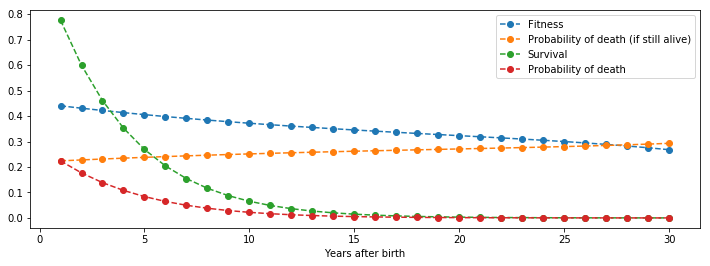

In [14]:
a = np.arange(1, 30.5)
w = hp['w_birth'] * (1-hp['eta'])**a
fit = Phi(a, w)
Om = hp['omega'] * ( 1 - fit )
S = np.cumprod(1-Om)
D = Om * S / (1 - Om)  # dividing is same as not multiplying final term

plt.plot(a, fit, 'o--', label='Fitness');
plt.plot(a, Om, 'o--', label='Probability of death (if still alive)');
plt.plot(a, S, 'o--', label='Survival');
plt.plot(a, D, 'o--', label='Probability of death');

plt.xlabel('Years after birth')
plt.legend();

- The chance to survive up to 25 years is very small
- Fitness changes only slowly
- The average lifetime, i.e., average time at death, is

In [15]:
np.sum(a * D)

4.268152588625437

- Newborns who are not fed die on average after 4.3 years
- To see the effect of different birth weights, we consider a large and a small birth weight

In [16]:
a = np.arange(1, 30.5)
w_lo = (hp['w_birth']-2*hp['sigma_birth']) * (1-hp['eta'])**a
w_hi = (hp['w_birth']+2*hp['sigma_birth']) * (1-hp['eta'])**a

Om_lo = hp['omega']*(1-Phi(a, w_lo))
Om_hi = hp['omega']*(1-Phi(a, w_hi))

D_lo = Om_lo / ( 1 - Om_lo ) * np.cumprod(1-Om_lo)
D_hi = Om_lo / ( 1 - Om_hi ) * np.cumprod(1-Om_hi)

print("Lifetime (low birthweight):", np.sum(a * D_lo) )
print("Lifetime (high birthweight):", np.sum(a * D_hi) )

Lifetime (low birthweight): 3.8906607716379282
Lifetime (high birthweight): 5.570610269144378


- Lifetimes depend on birth weight
- Roughly ranging from 4 to 6 years

#### Size of surviving newborn population

- Assume $B$ animals are born every year, and have been forever
- Then, the total number of "newborns" alive at the end of year $n$ is
    - surviving newborns from this year, on average $B(1-\Omega_1)$
    - surviving newborns from the previous year, on average $B(1-\Omega_1)(1-\Omega_2)$
    - etc
- Thus, the total number of "newborns" (animals that never fed after birth) is
\begin{equation}
T = B\sum_{n=1}^{\infty}\Pi_{k=1}^{n} (1-\Omega_k)
\end{equation}
- $T$ is the average number of animals expected, the distribution is more complicated 
- We need to find $T$ numerically, clipping the infinite sum

In [17]:
T_lo = np.sum(np.cumprod(1-Om_lo))
T_hi = np.sum(np.cumprod(1-Om_hi))

print("Relative size of surviving population (low birthweight):", T_lo)
print("Relative size of surviving population (high birthweight):", T_hi)

Relative size of surviving population (low birthweight): 2.892707633455089
Relative size of surviving population (high birthweight): 3.7334304787909067


- The population of starving young animals is about 3 to 4 times as large as the number of newborns joining it each year.

#### Size of starving old animals

- Assume that animals begin starving after they have given birth, weight around 25, and at age 35

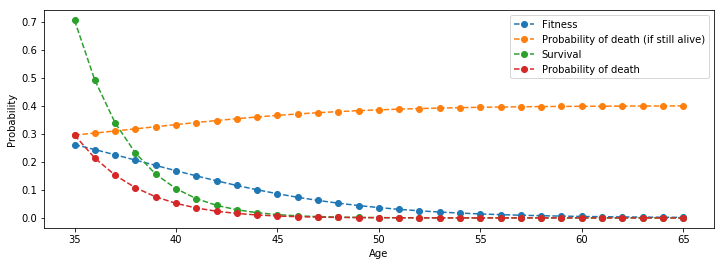

In [18]:
a = np.arange(35, 65.5)
w = 25 * (1-hp['eta'])**a
f = Phi(a, w)
Om = hp['omega'] * ( 1 - f )
S = np.cumprod(1-Om)
D = Om * S / (1 - Om)  # dividing is same as not multiplying final term

plt.plot(a, f, 'o--', label='Fitness');
plt.plot(a, Om, 'o--', label='Probability of death (if still alive)');
plt.plot(a, S, 'o--', label='Survival');
plt.plot(a, D, 'o--', label='Probability of death');
plt.xlabel('Age')
plt.ylabel('Probability')
plt.legend();

In [19]:
print("Average age at death:", np.sum(a*D))
print("Relative size of starving population:", np.sum(S))

Average age at death: 37.219575867071335
Relative size of starving population: 2.219613682918252


### Evolution of juvenile who gets to feed

- We assume sufficiently many other animals of same species that birth is certain if possible
- We assume baby is born with above-average birth weight to have chance to feed

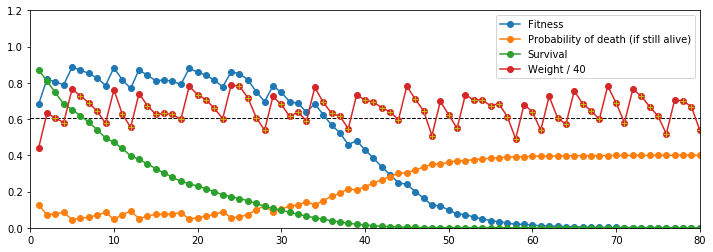

In [20]:
w_old = hp['w_birth']+hp['sigma_birth']
num_years = 80
a = np.arange(1, num_years + 0.5)
w = np.zeros(num_years)
birth_years = []
for n in range(num_years):    
    w_old += hp['beta'] * hp['F']
    if w_old >= hp['zeta'] * ( hp['w_birth'] + hp['sigma_birth'] ):
        bw = np.random.normal(hp['w_birth'], hp['sigma_birth'])
        w_old -= hp['xi'] * bw
        birth_years.append(n)
    w_old *= (1-hp['eta'])
    w[n] = w_old
f = Phi(a, w)
Om = hp['omega'] * (1-f)
S = np.cumprod(1-Om)
D = Om / ( 1 - Om ) * S

plt.axhline(y= (hp['zeta'] * ( hp['w_birth'] + hp['sigma_birth'] )-hp['beta']*hp['F'])/40., 
            linewidth=1, color='k', linestyle='--')
plt.plot(a, f, 'o-', label='Fitness')
plt.plot(a, Om, 'o-', label='Probability of death (if still alive)')
plt.plot(a, S, 'o-', label='Survival')
#plt.plot(a, D, 'o-', label='Probability of Death')
plt.plot(a, w/40, 'o-', label='Weight / 40')
plt.plot(a[birth_years], w[birth_years]/40, 'y+')
plt.axis([0, 80, 0, 1.2])
plt.legend();

- Graph shows values at *end* of year
- Weight values with yellow `+` are from years with birth
- For years in which animals give birth, this means that 
    - the animal first feeds, crossing the fertility threshold
    - gives birth and loses weight due to birth
    - we thus see the post-birth weight of the mother
- Dashed black line is minimum weight to be able to give birth the *following* year
- What is the expected average lifetime of an animal?

In [21]:
"Average lifetime:", np.sum(a * D)

('Average lifetime:', 12.71322752042997)

### Expected population size

We shall try to estimate the population size based on previous estimations and some assumptions.

- In its good years (up to 30), fitness of "adults" rarely drops below 0.75
- What is fitness of very fit newborns (top 0.5%)?

In [22]:
Phi(0, hp['w_birth']+3*hp['sigma_birth'])

0.5619879749228809

- Cannot compete with any "adult" under age 40
- Number of "growing" newborns corresponds to number of dying or "retiring" adults
- Assume number of feeding/breeding adults is $A=F_{\text{avail}}/F$ (Jungle supports 800/10 = 80 individuals)
- Assume retiring at 35, then average number of adult losses is given by death probability up to 35 and survival probability to 35

In [23]:
A = 800. / hp['F']
dA = np.mean(D[:35]) * A
rA = S[35] * A
A, dA, rA

(80.0, 2.1772567792581006, 3.138371238004237)

- We have 80 feeding and breeding animals, about 2 die, 3 retire each year
- About 5.5 newborns can feed per year and grow up, all others starve
- We saw above that 
    - the size of the starving children population is approx 3 times then number of non-feeding newborns
    - the size of the starving retiree population is about 2.2 times the number of retirees
- Thus, the total population size would be approximately
$$A + 3 \times (A - dA - rA) + 2.2 \times rA$$

In [24]:
A + 3 * ( A - dA - rA ) + 2.0 * rA

310.3298584242214

- Right ballpark, but many approximations and assumptions made

#### Refined model

- Above, we did not consider that newborns take about 3 years to gain enough wait to give birth
- Every year, $dA+rA$ newborns survive
    - these need about 3 years to become mature
    - thus, we have $2(dA+rA)$ "juveniles" who feed, but do not breed
    - the number of newborns is thus not $A$, but $A-2(dA+rA)$
    - provided $A-2(dA+rA)\gg dA+rA$, this will not affect the number of newborns getting to feed and growing up
    - only the size of the starving children population is affected
- The total population size would thus become
\begin{equation}
A + 3\times(A- 3\times(dA+rA)) + 2.2\times rA
\end{equation}

In [25]:
A + 3 * ( A - 3 * (dA + rA) ) + 2.0 * rA

278.43609032064745

- This is still a ballpark figure, but it does provide a sanity check for our simulations!